## Function definitions and Prompt templates

In [403]:
import re, os, random, time, math
from datetime import date, datetime
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from pyathena import connect
import boto3
from botocore.exceptions import ClientError
import openai
from openai import OpenAI
import json
import pyarrow.parquet as pq
import tiktoken
import faiss
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings

%matplotlib inline
sns.set_theme()

In [6]:
class SecretManager:
    def __init__(self, secret_name, region_name="us-east-1"):
        self.secret_name = secret_name
        self.region_name = region_name
        self.client = boto3.session.Session().client(
            service_name='secretsmanager', 
            region_name=region_name
        )
        
    def get_secret(self, api_key_name):
        try:
            get_secret_value_response = self.client.get_secret_value(
                SecretId=self.secret_name
            )
        except ClientError as e:
            # For a list of exceptions thrown, see
            # https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
            raise e

        secret = get_secret_value_response['SecretString']

        return json.loads(secret)[api_key_name]

In [7]:
class S3ParquetLoader:
    def __init__(self, bucket_name, prefix, file_identifier="s3://"):
        self.bucket_name = bucket_name
        self.prefix = prefix
        self.file_identifier = file_identifier
        
    def load_s3_parquet(self, file):
        s3_path = self.file_identifier + self.bucket_name + self.prefix + file
        return pq.read_table(s3_path).to_pandas()

In [8]:
class OpenAIClient:
    def __init__(self, model='gpt-4o-mini', seed=12345, temperature=0, tools=None):
        self.model = model
        self.seed = seed
        self.temperature = temperature
        self.tools = tools
        self.client = OpenAI()
    
    def get_completion(self, message):
        response = self.client.chat.completions.create(
            model=self.model,
            response_format={ "type": "json_object" },
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant designed to output JSON.",
                },
                {"role": "user", "content": message},
            ],
            temperature=self.temperature,
            # max_tokens=max_tokens,
            seed=self.seed,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0 # seed=1001
    )
    
        return response # response_format={ "type": "json_object"}, designed to output JSON

In [9]:
class TpwireDataLoader:
    def __init__(self, bucket_name, prefix, file_identifier="s3://"):
        self.s3_loader = S3ParquetLoader(bucket_name, prefix, file_identifier)
        
    def process_data(self, file_name):
        data = self.s3_loader.load_s3_parquet(file_name)
        # final_df = data[['summaryplaintext', 'publishdate', 'multi_story_flag', 'table_flag']]
        final_df = data
        final_df = final_df[(final_df['multi_story_flag'] == False) & (final_df['table_flag'] == False)]
        
        # tpwire_df = final_df[['summaryplaintext', 'publishdate']]
        tpwire_df = final_df.drop(['multi_story_flag', 'table_flag'], axis=1)
        tpwire_df = tpwire_df.sort_values(by='publishdate').reset_index(drop=True)
        tpwire_df['publishdate'] = tpwire_df['publishdate'].apply(lambda x: np.datetime64(x).astype(datetime).date()) # change to standard date format
        
        return tpwire_df

In [247]:
class tpwireRAG:
    def __init__(self, embed):
        self.embed = embed
        self.index_tb = None
        self.vec_db = None
        self.prompt_template = '''
        Use the following pieces of context to help you answer the question at the end. 

        If you don't know the answer, just output: "Answer": <I don't know the answer>. Don't try to make up an answer. 

        Keep the answer as concise as possible.

        Context: {context}
        Question: {search_text}
        
        "Answer": <answer> 
        ''' # Always say "thanks for asking!" at the end of the answer.
        self.ranking_prompt_template = """
            Rank the following commercial real estate credit stories based on their relevance to the given query. Each story is represented by an index and its content.

            The stories are provided in the following format:
            [
                {{ "index": index1, "story": story1 }},
                {{ "index": index2, "story": story2 }},
                ...
                {{ "index": indexN, "story": storyN }}
            ]

            Query: {query}
            Stories: {stories}

            Output the ranked story indices in JSON format:
            {{
                "ranking": [
                    index1,
                    index2,
                    ...
                    indexN
                ]
            }}
            where index1 > index2 > index3 > ... > indexN
        """
        
    def index_document(self, df):
        # for idx in range(len(df)):
        chunks = df['summaryplaintext'].tolist()
        
        self.index_tb = pd.DataFrame({
        'Content': chunks,
        'Vectors': embed.embed_documents(chunks), # 'original_index': range(len(chunks)),
        })

        self.index_tb.reset_index(drop=True, inplace=True)

        return self.index_tb
    
    def build_vec_db(self, index_tb):
        if not self.index_tb:
            self.index_tb = index_tb
        
        vectors = np.array(self.index_tb['Vectors'].tolist(), dtype='float32')
        vec_dim = vectors.shape[1]
        self.vec_db = faiss.IndexFlatL2(vec_dim)
        faiss.normalize_L2(vectors)
        self.vec_db.add(vectors)

        # return self.vec_db
        
        
    def retrieve_from_vec_db(self, search_text, K):
        search_vectors = self.embed.embed_documents([search_text])
        faiss.normalize_L2(np.array(search_vectors, dtype='float32'))

        distances, ann = self.vec_db.search(np.array(search_vectors, dtype='float32'), k=K)

        results = pd.DataFrame({'distances': distances[0], 'ann': ann[0]})

        merge = pd.merge(results, self.index_tb, left_on='ann', right_index=True)

        # # If you need data from the original dataframe:
        # merge = pd.merge(merge, original_df, left_on='original_index', right_index=True)

        return merge
    
    @staticmethod
    def combine_context(relevant_contents): # Helper function for generating context
        context = relevant_contents.Content
        context = '\n'.join(context)

        return context
    
    def generate_context_prompt(self, search_text, K1, K2):
        # relevant_contents = self.retrieve_from_vec_db(search_text=search_text, K=K)
        # context = self.combine_context(relevant_contents=relevant_contents)
        # prompt = self.prompt_template.format(context=context, search_text=search_text)
        # return relevant_contents, prompt 
        # stage 1: retrieval
        relevant_contents1 = self.retrieve_from_vec_db(search_text=search_text, K=K1)
        
        # stage 2: reranking
        stories = [{row['ann']: row['Content']} for _, row in relevant_contents1.iterrows()]
        ranking_prompt = self.ranking_prompt_template.format(query=search_text, stories=stories)
        response = openai_client.get_completion(message=ranking_prompt)
        rank_index = json.loads(response.choices[0].message.content)['ranking'][:K2]
        
        relevant_contents = relevant_contents1[relevant_contents1.apply(lambda x: x['ann'] in rank_index, axis=1)]
       
        
        context = self.combine_context(relevant_contents=relevant_contents)
        prompt = self.prompt_template.format(context=context, search_text=search_text)
        # return relevant_contents, prompt 
        return relevant_contents1, relevant_contents, prompt 

## Initialize env and class

### Setting env variables

In [249]:
# API key setting
SECRET_NAME= "AmazonSageMaker-sagemarker_yuwen"
secret_manager = SecretManager(secret_name=SECRET_NAME)
os.environ['OPENAI_API_KEY'] = secret_manager.get_secret('OPENAI_API_KEY')

### Set constant variable

In [348]:
BUCKET_NAME, PREFIX = "trepp-developmentservices-datascience/", "llm-exploration/treppwire_rag/"

MODEL = 'gpt-4o-mini'
EMBED_MODEL_NAME = 'text-embedding-ada-002'
embed = OpenAIEmbeddings(model=EMBED_MODEL_NAME) # Create embeddings for indexing documents
K = 5 # Number of relevant chunks
K1, K2 = 10, 5

### Class initialization

In [349]:
openai_client = OpenAIClient(model=MODEL)

# S3 parquet loader
s3_parquet_loader = S3ParquetLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

# Import TreppWire data
tpwire_loader = TpwireDataLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

# Initialize treppwire RAG
tpwire_RAG = tpwireRAG(embed=embed)

## Import data

In [350]:
tpwire_df = tpwire_loader.process_data("tpwire_flags.parquet")
tpwire_df

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
0,3eed7ccc305ff0e7d259fecacaa0c241fd48015d8ef413...,50998,mclancy@trepp.com,Manus Clancy,TreppWire,post,[DBJPM 2016-C3],<h4><strong>Purchase of Seattle-Area Office Fi...,Purchase of Seattle-Area Office FinalizedThe R...,[390132],...,[Medical Office],[Office],[OF],[CA],[Alameda],[Oakland],"[San Francisco-Oakland-Hayward, CA]",[1 Kaiser Plaza],[Pacific],2019-01-02
1,c187de254e73aff2b22b7f25efc7945dc8ce89bcba7f7f...,50998,mclancy@trepp.com,Manus Clancy,TreppWire,post,[DBJPM 2016-C3],<h4><strong>San Francisco Office Behind 2017 L...,San Francisco Office Behind 2017 Loan Acquired...,[390132],...,[Medical Office],[Office],[OF],[CA],[Alameda],[Oakland],"[San Francisco-Oakland-Hayward, CA]",[1 Kaiser Plaza],[Pacific],2019-01-02
2,aa0de93c31614f2533617779d6343a6f6c708ba9017046...,51027,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2013-GC14],<ul>\n<li>The overall US CMBS delinquency rate...,The overall US CMBS delinquency rate decrease...,[329689],...,[Community Shopping Center],[Retail],[RT],[IL],[Peoria],[Peoria],"[Peoria, IL]",[Willow Knolls Court],[East North Central],2019-01-03
3,e235e5b2038f2617902d3ca0b75d19ce84f927bffba8a2...,51027,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2013-GC14],<h4><strong>Retail Property Behind CMBX 7 Loan...,Retail Property Behind CMBX 7 Loan to Lose Top...,[329689],...,[Community Shopping Center],[Retail],[RT],[IL],[Peoria],[Peoria],"[Peoria, IL]",[Willow Knolls Court],[East North Central],2019-01-03
4,0f5e20e57aafb684eb5a2051f816f114154ae9a75a7849...,51027,mclancy@trepp.com,Manus Clancy,TreppWire,post,[GSMS 2013-GC14],<ul>\n<li>The CMBS 1.0 delinquency rate decrea...,The CMBS 1.0 delinquency rate decreased 47 ba...,[329689],...,[Community Shopping Center],[Retail],[RT],[IL],[Peoria],[Peoria],"[Peoria, IL]",[Willow Knolls Court],[East North Central],2019-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,f2d51a2006a5e8e7b09b94d11a9af692135b26682f8d7f...,57207,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<table cellpadding=""0"" cellspacing=""0"" role=""p...",⇨ Orange County Mall Loan Now in the Han...,[],...,[],[],[],[],[],[],[],[],[],2024-03-26
3614,0c5f0453b3cae3512de98a3119ed3ddfbd576ec6102011...,57211,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<table cellpadding=""0"" cellspacing=""0"" role=""p...",⇨ Cupertino Hilton Hotel Loan Transferre...,[],...,[],[],[],[],[],[],[],[],[],2024-03-27
3615,1412c58f039f440abb93bbab6eeef528dcf91a2959f889...,57211,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<table cellpadding=""0"" cellspacing=""0"" role=""p...",⇨ San Francisco Office Loan Taken to Spe...,[],...,[],[],[],[],[],[],[],[],[],2024-03-27
3616,57bab2bd3ab498abe44a50d3e0c9069f46f39074e8e6a7...,57214,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<table cellpadding=""0"" cellspacing=""0"" role=""p...",⇨ Bankruptcy Filed for Washington D.C. O...,[],...,[],[],[],[],[],[],[],[],[],2024-03-28


In [351]:
# index_tb = index_document(tpwire_df, embed)
# index_tb = tpwire_RAG.index_document(tpwire_df)
# index_tb.to_parquet('treppwire_index_tb.parquet')

In [353]:
# index_tb = pd.read_parquet('treppwire_index_tb.parquet')
index_tb = s3_parquet_loader.load_s3_parquet('treppwire_index_tb.parquet')

In [354]:
index_tb

,Content,Vectors
0,Purchase of Seattle-Area Office FinalizedThe R...,"[0.013301508501172066, -0.009327195584774017, ..."
1,San Francisco Office Behind 2017 Loan Acquired...,"[0.0029433900490403175, -0.01179976761341095, ..."
2,The overall US CMBS delinquency rate decrease...,"[-0.034419845789670944, 0.001670714351348579, ..."
3,Retail Property Behind CMBX 7 Loan to Lose Top...,"[-0.01970122568309307, -0.014349104836583138, ..."
4,The CMBS 1.0 delinquency rate decreased 47 ba...,"[-0.016646970063447952, -0.0006964138592593372..."
...,...,...
3613,⇨ Orange County Mall Loan Now in the Han...,"[-0.004349840339273214, -0.016529392451047897,..."
3614,⇨ Cupertino Hilton Hotel Loan Transferre...,"[-0.003111459081992507, -0.01287689059972763, ..."
3615,⇨ San Francisco Office Loan Taken to Spe...,"[-0.0039004357531666756, -0.019137587398290634..."
3616,⇨ Bankruptcy Filed for Washington D.C. O...,"[-0.02221551537513733, -0.005892913788557053, ..."


In [355]:
tpwire_RAG.build_vec_db(index_tb=index_tb)

## Retrieve most K=5 relevant chunks from vector database

In [356]:
# search_text = 'What percentage of space does the Kroger grocery store occupy in the Northern Lights Shopping Center loan that will end in 2019?'
# search_text = 'What top tenants vacates in the Northern Lights Shopping Center Loan?'
# search_text = 'Could you tell me what happened with CMBS Loans in October 2023 in a concise manner? Thanks.'
# search_text = 'What was DSCR for Mall at Tuttle Crossing loan in 2022?'
# search_text = 'Could you give me information about Solano Mall loan?'
# search_text = 'Could you give me information about the property backed behind Solano Mall loan?'
# search_text = 'What do you think about the future of commercial real estate loans in USA?'
# search_text = 'How was loan default situation for New York comparing with California?'
# search_text = 'What commerical real estate loans we have to pay attention to this year 2024?'
# search_text = 'Is there anything about the NYC Worldwide Plaza?'
# search_text = 'What is the current status of Ohio Mall in the latest credit story?'
# search_text = 'Can you provide an overview of the financial details for Ohio Mall Loan recorded this month?'
# search_text = 'How has the occupancy rate for Ohio Mall changed in the recent report?'
# search_text= 'What is the most recent status of Big Philly Office Loan?'
# search_text = 'What are the key updates about the sale of Dulaney Center?'
# search_text = 'Can you provide an overview about National Business Park loan?'
# search_text = 'How was the occupancy rate for Doner Company in the recent report?'
# search_text = 'Could you summarize the recent financial performance of Chicago Hotel?'
# search_text = 'What significant events have occurred for Chicago Hotel?'
# search_text = 'How has the value of Waterfront at Port Chester evolved according to the latest credit report?'
# search_text = 'What are the main points of concern for IDS Center loan mentioned this month?'
# search_text = 'Could you detail the transactions involving One Concords Center?'
# search_text = 'What are the highlights of the latest credit story for WeWork?'
# search_text = 'How was the delinquency status of Aviation Mall been addressed in the latest update?'
# search_text = 'What new information is available about the refinancing of [New York Hospitality Portfolio loan]?'
# search_text = 'Could you provide a brief on the recent sales details of Courtyard Louisville Airport?'
# search_text = 'What changes in valuation have been recorded for North Riverside Park Mall this month?'
# search_text = 'How does the latest credit story describe the financial health of SASB Office Loan?'
# search_text = 'Could you summarize the deal that Hughes Center Las Vegas belongs to?'
# search_text = 'Could you summarize the main details of sales of Ozarks Hotel?'
# search_text = 'Could you summarize the loan details of Ozarks Hotel?'
# search_text= 'What are the highlights of the special servicing history for Cupertino Hilton Hotel Loan?'
# search_text = 'Could you summarize the valuation changes for Cranberry Woods Office Park over the years?'

In [357]:
search_text = 'What is the recent price of Flagler Corporate Center loan?'
# search_text = 'How many square feet does the Bridgewater Commons mall in New Jersey contain?'
# search_text = 'What is the loan amount for the IDS Center property in Minneapolis?'
# search_text = 'What year was the Colman Building originated, has it undergone any renovations?'
# search_text = 'What is the occupancy rate of The Commons at Sawmill near Northern Arizona University?'
# search_text = 'How does the recent sale price of NMS Northridge and NMS Superior properties compare to their previous valuation?'
# search_text = 'Could you provide information on the location and size of the West Ridge Mall & Plaza?'
# search_text = 'What is the DSCR (NCF) for the 184-unit community in San Bernardino in the most recent quarter?'
# search_text = 'Who was the buyer in the recent transaction of Osprey Pointe Apartments in St. Petersburg?'
# search_text = 'Could you provide original loan amount and current status about the Fifth Avenue loan?'
# search_text = 'What percentage of the Starwood Mall Portfolio loan does the MacArthur Center Mall represent?'
# search_text = 'What type of property is the 644 Broadway loan, and what are its primary uses?'
# search_text = 'What recent updates have there been regarding the changes of properties associated with CMBX 6 deal?'
# search_text = 'How has the valuation of the Cincinnati Hotel changed since 2019?'
# search_text = 'Has the Enclave West student housing loan in Edwardsville been sent to special servicing? If so, when?'
# search_text = 'What recent changes have occurred with the Greentree Plaza retail center in Everett?'
# search_text = 'How does the current occupancy rate of Atlanta hotel compare to previous year?'
# search_text = 'Which CMBX series does the deal involving the San Isidro Plaza I & II loan belong to?'
# search_text = 'What is the current delinquency status of the loan backed by the US Bank Tower in Downtown Denver?'
# search_text = 'What is the maturity date of the loan backing the Alexander Place Apartments property in Charlotte?'

In [358]:
# search_text = 'What are the top 5 largest transactions by dollar amount in Manhattan this quarter this month?'
# search_text = 'Can you list all office properties in Houston, TX with a loan amount above $50 million?'
# search_text = 'How many office buildings were sold in West Palm Beach and Irmo during the first half of 2021?'
# search_text = 'What is the current occupancy rate for the Jacksonville retail property in Florida based on the latest available data?'
# search_text = 'Show me all properties built before 2010 that were sold in the last quarter.'
# search_text = 'Which property in Elizabeth, NJ had the highest price per square foot this year?'
# search_text = 'What are the 3 most recent transactions for properties larger than 200,000 square feet in Texas?'
# search_text = 'Which properties in Akron, Ohio have experienced a significant decrease in occupancy due to tenant turnover in the past year?'
# search_text = "What's the total value of all retail properties in Lakeland, FL that have undergone appraisal reductions in the past quarter?"
# search_text = 'What is the total transaction volume for the Huntsville, AL Apartments property in 2021?'
# search_text = 'How many properties in East Lansing, MI have a DSCR below 1.0?'
# search_text = "What's the average construction year of retail properties sold behind CMBX 12 loans?"
# search_text = 'List all properties where the largest tenant represents over 80% of underwritten base rent'
# search_text = 'How many properties in New York City are currently facing foreclosure?'
# search_text = 'What is the total square footage of all properties involved in the recent credit stories?'
# search_text = 'Can you show me all transactions in Tampa, FL where the occupancy rate decreased by at least 20% post-sale?'
# search_text = 'List the 5 largest loans (by dollar amount) that were sent to special servicing in Region S this quarter.'
# search_text = "What's the average lease renewal duration for retail properties in Chicago in the last 12 months?"
# search_text = 'What properties in Pennsylvania sold for more than $5 million and less than $15 million recently?'
# search_text = 'Can you rank the top 3 buyers by total square footage acquired in Manhattan for office properties this quarter?'
# search_text = 'Could you provide information on any credit stories related to loan modifications or paydowns for properties in the last quarter?'
# search_text = 'What are the recent credit stories involving properties with appraisal reductions?'
# search_text = 'Could you provide information on loans that are currently in special servicing?'
# search_text = 'Are there any credit stories from this month regarding properties undergoing refinancing or loan modifications?'
# search_text = 'Can you provide credit stories where there have been significant changes in occupancy rates and DSCR for loans or properties?'

### Hallucination (data point retrieval)

In [359]:
# search_text = 'How many multifamily communities were sold in Las Vegas in 2018?'
# search_text = 'Show me all properties built before 1975 that were sold in the last quarter.'
# search_text = 'What was the recent sale price of Property X?'
# search_text = 'When was Avalon Riverview, Long island city constructed, and has it undergone any renovations?'
# search_text = 'What are the primary uses of Macy"s?'
# search_text = 'What''s the average age of office buildings sold this quarter?'
# search_text = 'What is the CMBX series that the Dartmouth Mall loan is part of?'
# search_text = 'What is the current occupancy rate of the Empire State Building in New York, NY?'
# search_text = 'Has there been any recent news or updates regarding the sale of the 55 Green Street property?'
# search_text = 'Has the loan behind the North Carolina medical office building been refinanced recently?'
# search_text = 'What is the current vacancy rate of the Blackwell Plaza property?'
# search_text = 'What is the recent DSCR of the $108.8 million Embassy Suites loan backing the JPMCC 2019-EMBS deal in Manhattan?'
# search_text = 'What caused the significant drop in occupancy rate at Jackson Park in Long Island City from 96% in 2019 to 59% in September 2018?'
# search_text = 'What''s the LTV of Gotham Point property in Queens?'
# search_text = 'Who was the buyer in the recent transaction of Rockefellar Center?'
# search_text = 'What is the current outstanding balance of the 55 Broadway loan?'
# search_text = 'What was the DSCR (NCF) for Crossgates Mall in 2021?'
# search_text = 'What is the likelihood of Schwab subletting the space at 211 Main Street in San Francisco?'
# search_text = 'How has the valuation of Property X changed over the past few years?'
# search_text = 'What"s the location and size of property X?'
# search_text = 'How many square feet does 55 Broadway loan have?

### Hallucination (general summary)

In [360]:
# search_text = 'List the 3 most recent transactions for properties larger than X square feet in State G.'
# search_text = 'Could you provide an overview of for Rockefeller Center loan?'
# search_text = 'What significant events have occurred for Chicago Hotel in 2024?' 
# search_text = 'What are the key updates about the sale of Rockefeller Center in 2024?'
# search_text = 'What are the highlights of credit story for North Carolina medical office building in 2018?'
# search_text = 'Could you summarize the deal that property X belongs to?'
# search_text = 'What changes in valuation have been recorded for Hmart Mall?'
# search_text = 'Could you summarize the main details of transactions of New York Central Park?'
# search_text = 'How was the delinquency status of Empire State Building been addressed in the latest update?'
# search_text = 'Could you provide the details about world trade center sent to special servicing?'
# search_text = 'What was the loss severity percentage for the Jacksonville retail property loan resolution this month?'
# search_text = 'What impact does the transition of property to the lender have on the financial health of Virginia Mall Loan?'
# search_text = 'What modifications were made to the loan for 11 West 42nd Street property in June 2018?'
# search_text = 'What are the main factors contributing to the imminent default of the Fifth Avenue loan in Washington, DC?'
# searc_text = 'What was the outcome of the bankruptcy auction for the Lower Manhattan mixed-use property at 78 Bowery Street?'
# search_text = 'What was the resolution outcome for the Rockefeller Center loan in New York, NY?'
# search_text = 'What impact did the departure of Clock Tower Village have on the Fox River Mall loan?'
# search_text = 'What are the implications of the recent tenant changes at One Newark Center for the Cupertino Hilton Hotel Loan?'
# search_text = 'How has the value of Crossgates Mall loan evolved this year?'
# search_text = 'What was the final outstanding balance loss percentage for the Ozarks Hotel property asset resolution?'

### Hallucination (Metadata filtering)

In [361]:
# search_text = 'What are the 5 transactions in New York in Dec, 2023?'
# search_text = 'What"s the average time on market for Property Type Multifamily sold in New York in the last 6 months?'
# search_text = 'What was the occupancy rate of The Clusters apartment community at 4416 Northcrest Drive in Midland, TX in 2019?'
# search_text = 'What properties in State NY sold for more than $10 million and less than $100 million this year?'
# search_text = 'What was the Bank of America Plaza Loan DSCR in 2022?'
# search_text = 'What is the total Loan Per Square Foot (LPSF) for Bank of America Plaza in St. Louis?'
# search_text = "What's the total Jamaica Center Cinema lease length?"
# search_text = 'Has the East Village Multifamily Portfolio Pool 2 loan LTV increased since securitized? If so, how much of the increase.'

In [364]:
# relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K=K)
relevant_contents1, relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K1=K1, K2=K2)

In [365]:
relevant_contents

,distances,ann,Content,Vectors
0,0.247765,3469,Big Change Coming for Big Miami Office Loan?Mo...,"[-0.0012216087197884917, -0.009146752767264843..."
1,0.247765,3472,Big Change Coming for Big Miami Office Loan?Mo...,"[-0.0012216087197884917, -0.009146752767264843..."
6,0.313321,1900,Trading Alert: Formerly Delinquent Miami Retai...,"[-0.02053123153746128, -0.00990400929003954, -..."
8,0.317079,1030,Value of FL Retail Property Cut SharplyAccordi...,"[-0.005366169847548008, -0.010996249504387379,..."
12,0.324327,1321,Stake Sale Set New Value for Miami OfficeThe R...,"[-0.018225939944386482, 0.001539260963909328, ..."


## Combine context AND output answer

In [267]:
response = openai_client.get_completion(message=prompt)

In [268]:
json.loads(response.choices[0].message.content)['Answer']

'$205 million'

In [ ]:
# tpwire_df.summaryplaintext[1800]

# Execution

In [1]:
import os, json
from langchain_openai import OpenAIEmbeddings
from utils_rag import SecretManager, OpenAIClient, S3ParquetLoader, TpwireDataLoader, tpwireRAG
from config import SECRET_NAME, BUCKET_NAME, PREFIX, MODEL, EMBED_MODEL_NAME, K1, K2

In [3]:
if __name__ == '__main__':
    embed = OpenAIEmbeddings(model=EMBED_MODEL_NAME) # Create embeddings for indexing documents
    
    secret_manager = SecretManager(secret_name=SECRET_NAME)
    os.environ['OPENAI_API_KEY'] = secret_manager.get_secret('OPENAI_API_KEY')
    
    openai_client = OpenAIClient(model=MODEL)

    # S3 parquet loader
    s3_parquet_loader = S3ParquetLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

    # Import TreppWire data
    tpwire_loader = TpwireDataLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

    # Initialize treppwire RAG
    tpwire_RAG = tpwireRAG(client=openai_client, embed=embed)
    
    tpwire_df = tpwire_loader.process_data("tpwire_flags.parquet")
    
    
    # index_tb = index_document(tpwire_df, embed)
    # index_tb = tpwire_RAG.index_document(tpwire_df)
    # index_tb.to_parquet('treppwire_index_tb.parquet')
    
    # index_tb = pd.read_parquet('treppwire_index_tb.parquet')
    index_tb = s3_parquet_loader.load_s3_parquet('treppwire_index_tb.parquet')
    
    tpwire_RAG.build_vec_db(index_tb=index_tb)
    
    
    search_text = 'What is the recent price of Flagler Corporate Center loan?'
    
    relevant_contents1, relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K1=K1, K2=K2)
    response = openai_client.get_completion(message=prompt)
    print(f"The answer is: {json.loads(response.choices[0].message.content)['Answer']}")

The answer is: The recent price of the Flagler Corporate Center loan is $205 million, as Miami-Dade County could acquire the property for that amount.


## * Evaluation

### 1. General summary questions

In [366]:
# General Summary questions
test_context = [
    'What is the most recent status of Big Philly Office Loan?',
    'What are the key updates about the sale of Dulaney Center?',
    'Can you provide an overview of for National Business Park loan?',
    'How was the occupancy rate for Doner Company in the recent report?',
    'Can you summarize the recent financial performance of Chicago Hotel?',
    'What significant events have occurred for Chicago Hotel (after 2022)?',
    'How has the value of Waterfront at Port Chester loanevolved according to the latest credit report?',
    'What are the main points of concern for IDS Center loan mentioned (this month)?',
    'Can you detail the (recent) transactions involving One Concords Center?',
    'What are the highlights of the latest credit story for WeWork?',
    'How was the delinquency status of Aviation Mall been addressed in the latest update?',
    'What new information is available about the refinancing of New York Hospitality Portfolio loan?',
    'Could you provide a brief on the recent sales details of Courtyard Louisville Airport?',
    'What changes in valuation have been recorded for North Riverside Park Mall (this month)?',
    'How does the latest credit story describe the financial health of SASB Office Loan?',
    'Could you summarize the deal that Hughes Center Las Vegas belongs to?',
    'Could you summarize the main details of sales of Ozarks Hotel?',
    'Could you summarize the loan details of Ozarks Hotel?',
    'What are the highlights of the special servicing history for Cupertino Hilton Hotel Loan?',
    'Could you summarize the valuation changes for Cranberry Woods Office Park (over the years)?',
]

In [367]:
ground_truth = [
    [3341],
    [3431],
    [3159],
    [3488],
    [3080],
    [1546, 1181],
    [3160, 3170],
    [3177],
    [3206],
    [3489],
    [3452],
    [3432],
    [3401],
    [3571],
    [3268, 2849, 2089],
    [3502],
    [3546],
    [3546],
    [3614],
    [3551],
]

In [323]:
relevant_contents1, relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=test_context[6], K1=K1, K2=K2)
relevant_contents

,distances,ann,Content,Vectors
0,0.246618,1134,Value of Suburban NY Shopping Center ReducedAc...,"[-0.009347003884613514, -0.01151452399790287, ..."
1,0.252218,3170,Suburban NYC Retail Loan Goes 30 Days Delinque...,"[-0.006137296091765165, -0.025809893384575844,..."
4,0.329223,1129,Change of Course for South Florida MallAccordi...,"[-0.0073425243608653545, -0.001835631090216338..."
7,0.335877,1014,Value of NYC Recreation/Retail Property Cut Su...,"[0.0008722125785425305, -0.006794255692511797,..."
8,0.337792,1030,Value of FL Retail Property Cut SharplyAccordi...,"[-0.005366169847548008, -0.010996249504387379,..."


In [368]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents1, relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K1=K1, K2=K2)
    overlap = set(relevant_contents['ann'].tolist()).intersection(set(ground_truth[i]))
    res.append(list(overlap))

res

[[3341],
 [3431],
 [3159],
 [3488],
 [3080],
 [1546, 1181],
 [3170],
 [3177],
 [3206],
 [3489],
 [3452],
 [3432],
 [3401],
 [3571],
 [2849, 3268],
 [3502],
 [3546],
 [3546],
 [3614],
 [3551]]

### 2. Data point retrieval

In [369]:
test_context = [
    'What is the recent price of Flagler Corporate Center loan?',
    'How many square feet does the Bridgewater Commons mall in New Jersey contain?',
    'What is the loan amount for the IDS Center property in Minneapolis?',
    'What year was the Colman Building originated, has it undergone any renovations?',
    'What is the (current) occupancy rate of The Commons at Sawmill near Northern Arizona University?',
    'How does the recent sale price of NMS Northridge and NMS Superior properties compare to their previous valuation?',
    'Could you provide information on the location and size of the West Ridge Mall & Plaza?',
    'What is the DSCR (NCF) for the 184-unit community in San Bernardino (in the most recent quarter)?',
    'Who was the buyer in the (recent) transaction of Osprey Pointe Apartments in St. Petersburg?',
    'Could you provide original loan amount and current status about the Fifth Avenue loan?',
    'What percentage of the Starwood Mall Portfolio loan does the MacArthur Center Mall represent?',
    'What type of property is the 644 Broadway loan, and what are its primary uses?',
    'What recent updates have there been regarding the changes of properties associated with CMBX 6 deal?',
    'How has the valuation of the Cincinnati Hotel changed since 2019?',
    'Has the Enclave West student housing loan in Edwardsville been sent to special servicing? If so, when?',
    'What recent changes have occurred with the Greentree Plaza retail center in Everett?',
    'How does the current occupancy rate of Atlanta hotel compare to previous year?',
    'Which CMBX series does the deal involving the San Isidro Plaza I & II loan belong to?',
    'What is the current delinquency status of the loan backed by the US Bank Tower in Downtown Denver?',
    'What is the maturity date of the loan backing the Alexander Place Apartments property in Charlotte?',
]

In [370]:
ground_truth = [
    [3469],
    [2897],
    [198],
    [3188],
    [2133],
    [1836],
    [430],
    [2664],
    [1413],
    [3000, 2913],
    [3203],
    [2652],
    [2721],
    [2735],
    [338],
    [2608],
    [1452, 2305],
    [1444],
    [10],
    [1800],
]

In [ ]:
relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K1=K1, K2=K2)
overlap = set(relevant_contents['ann'].tolist()).intersection(set(ground_truth[i]))
res.append(list(overlap))

In [371]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents1, relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K1=K1, K2=K2)
    overlap = set(relevant_contents['ann'].tolist()).intersection(set(ground_truth[i]))
    res.append(list(overlap))

res

[[3469],
 [2897],
 [198],
 [3188],
 [2133],
 [1836],
 [430],
 [],
 [1413],
 [3000, 2913],
 [3203],
 [],
 [2721],
 [2735],
 [338],
 [2608],
 [2305, 1452],
 [1444],
 [],
 [1800]]

### 3. Metadata Filtering

In [372]:
test_context = [
    'What are the 5 transactions in New York in Dec, 2023?',
    'Can you list properties involved in deal FREMF 2019-K92?',
    'Could you list all stories about office properties in Houston, TX after 2020?',
    'What Convenience Center properties are in the Los Angeles-Long Beach-Anaheim, CA msa area?',
    'What loans in the MAD 2019-650M are in New York?',
    'What was the Bank of America Plaza Loan DSCR in 2022?',
    'What is the total Loan Per Square Foot (LPSF) for Bank of America Plaza in St. Louis?',
    'What was the occupancy rate increase of Bank of America Plaza in St. Louis from 2021 to 2022?',
    "What's the total  lease length of the Jamaica Center Cinema in Queens, NY?",
    'Has the East Village Multifamily Portfolio Pool 2 loan LTV increased since securitized? If so, how much of the increase.',
]

In [373]:
ground_truth = [
    [3484, 3486, 3489, 3491, 3499],
    [3525],
    [1188, 2215],
    [39, 194, 195, 2015],
    [959],
    [2979],
    [2979],
    [2979, 1921],
    [3526],
    [3528],
]

In [374]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents1, relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K1=K1, K2=K2)
    overlap = set(relevant_contents['ann'].tolist()).intersection(set(ground_truth[i]))
    res.append(list(overlap))

res

[[], [], [], [], [], [2979], [2979], [1921, 2979], [3526], [3528]]

### 4. Hallucination (General summary)

In [375]:
test_context = [
    'Which property behind the GSMS 2012-GC6 deal had the lowest occupancy rate in 2019?',
    'Could you provide an overview of for Rockefeller Center loan?',
    'What significant events have occurred for Chicago Hotel in 2024?',
    'What are the key updates about the sale of Rockefeller Center in 2024?',
    'What are the highlights of credit story for North Carolina medical office building in 2018?',
    'Could you summarize the deal that property X belongs to?',
    'What changes in valuation have been recorded for Hmart Mall?',
    'Could you summarize the main details of transactions of New York Central Park?',
    'How was the delinquency status of Empire State Building been addressed in the latest update?',
    'Could you provide the details about world trade center sent to special servicing?',
    'What was the loss severity percentage for the Jacksonville retail property loan resolution this month?',
    'What impact does the transition of property to the lender have on the financial health of Virginia Mall Loan?',
    'What modifications were made to the loan for 11 West 42nd Street property in June 2018?',
    'What are the main factors contributing to the imminent default of the Fifth Avenue loan in Washington, DC?',
    'What was the outcome of the bankruptcy auction for the Lower Manhattan mixed-use property at 78 Bowery Street?',
    'What was the resolution outcome for the Rockefeller Center loan in New York, NY?',
    'What impact did the departure of Clock Tower Village have on the Fox River Mall loan?',
    'What are the implications of the recent tenant changes at One Newark Center for the Cupertino Hilton Hotel Loan?',
    'How has the value of Crossgates Mall loan evolved this year?',
    'What was the final outstanding balance loss percentage for the Ozarks Hotel property asset resolution?',
]

In [376]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents1, relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K1=K1, K2=K2)
    response = openai_client.get_completion(message=prompt)
    res.append(json.loads(response.choices[0].message.content)['Answer'])
res

['State House Square in Hartford, Connecticut',
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 'DSCR NCF rose to 1.88x at YE 2019 from 1.69x at underwriting in 2015. Occupancy remained at 100%.',
 'Property X belongs to the FREMF 2016-KLH1 deal, which includes a Long Island portfolio of seven multifamily properties totaling 1,496 units that were acquired by Fairfield Properties and FCP joint venture for $472.5 million.',
 "I don't know the answer",
 'There are two main properties in New York Central Park area: 280 Park Avenue and 245 Park Avenue. 280 Park Avenue is backed by a $1.075 billion loan and has seen lease talks with Citadel and Franklin Templeton. 245 Park Avenue recently had a stake sold to Mori Trust for $1 billion, valuing the office at $2 billion. The property backs $1.8 billion in CMBS debt which matures in 2027.',
 'The delinquency status of Empire State Building was addressed by the borrower and special servicer coming to terms on 

In [377]:
[int(i == "I don't know the answer") for i in res]

[0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1]

### 5. Hallucination (Data point retrieval)

In [378]:
test_context = [
    'What is the current delinquency rate for lodging loans in the CMBS market?',
    'What was the recent sale price of Property X?',
    'When was Avalon Riverview, Long island city constructed, and has it undergone any renovations?',
    "What's the average age of office buildings sold this quarter?",
    'What is the CMBX series that the Dartmouth Mall loan is part of?',
    'What is the current occupancy rate of the Empire State Building in New York, NY?',
    'Has there been any recent news or updates regarding the sale of the 55 Green Street property?',
    'Has the loan behind the North Carolina medical office building been refinanced recently?',
    'What is the current vacancy rate of the Blackwell Plaza property?',
    'What is the recent DSCR of the $108.8 million Embassy Suites loan backing the JPMCC 2019-EMBS deal in Manhattan?',
    'What caused the significant drop in occupancy rate at Jackson Park in Long Island City from 96% in 2019 to 59% in September 2018?',
    'What''s the LTV of Gotham Point property in Queens?',
    'What percentage of deal K does the loan for property P represent?',
    'Who was the buyer in the recent transaction of Rockefeller Center?',
    'What is the current outstanding balance of the 55 Broadway loan?',
    'What was the DSCR (NCF) for Crossgates Mall in 2021?',
    'What is the likelihood of Schwab subletting the space at 211 Main Street in San Francisco?',
    'How has the valuation of Property X changed over the past few years?',
    'What"s the location and size of property X?',
    'How many square feet does 55 Broadway loan have?',
]

In [379]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents1, relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K1=K1, K2=K2)
    response = openai_client.get_completion(message=prompt)
    res.append(json.loads(response.choices[0].message.content)['Answer'])
res

['4.38%',
 'The recent sale price of Property X was $5.77 million.',
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 'There has been no recent news or updates regarding the sale of the 55 Green Street property.',
 "I don't know the answer",
 "I don't know the answer",
 "I don't know the answer",
 'The significant drop in occupancy rate at Jackson Park in Long Island City from 96% in 2019 to 59% in September 2020 was caused by a decline in occupancy levels over time, potentially due to factors such as market conditions, changes in demand, or other external factors affecting the property.',
 "I don't know the answer",
 '3.19%',
 "I don't know the answer",
 '$105 million',
 "I don't know the answer",
 'Likelihood of Schwab subletting the space at 211 Main Street in San Francisco is uncertain based on the provided context.',
 'The valuation of Property X has decreased from $146 million in 2018 to $79.9 million in November, an

In [380]:
[int(i == "I don't know the answer") for i in res]

[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]

### 6. Hallucination (Metadata Filtering)

In [381]:
test_context = [
    'What are the 5 transactions in New York in this quarter?',
    'Show me all properties built before 1975 that were sold in the last quarter.',
    'How many multifamily communities were sold in Las Vegas in 2018?',
    'List 5 properties undergoning renovation in the previous quarter?',
    'List the 3 most recent transactions for properties larger than X square feet in State G.',
    'List the 5 largest loans (by dollar amount) that were sent to special servicing in New York this quarter.',
    "What's the average time on market for Property Type Multifamily sold in City U in the last 6 months?",
    "What's the average time on market for Property Type Multifamily sold in New York in the last 6 months?",
    'What was the occupancy rate of The Clusters apartment community at 4416 Northcrest Drive in Midland, TX in 2019?',
    'What properties in State NY sold for more than $10 million and less than $100 million this year?',
]

In [382]:
res = []
for i, search_text in enumerate(test_context):
    relevant_contents1, relevant_contents, prompt = tpwire_RAG.generate_context_prompt(search_text=search_text, K1=K1, K2=K2)
    response = openai_client.get_completion(message=prompt)
    res.append(json.loads(response.choices[0].message.content)['Answer'])
res

['Global Relay USA at 1155 Sixth Avenue, Michelman & Robinson at 605 Third Avenue, HNA Group at 245 Park Avenue, Citadel at 280 Park Avenue, Best Buy at 535 Fifth Avenue',
 {'Property': 'Colonial Square',
  'Location': '3107 Boulevard, Colonial Heights, VA',
  'Loan Amount': '$13 million',
  'Loan Maturity': 'Late 2025',
  'Occupancy': '99%',
  'Top Tenant': 'Publix',
  'Year Built': 1967},
 2,
 "I don't know the answer",
 "I don't know the answer",
 '1. Manhattan Multifamily Portfolio - $270.3 million, 2. The Aire - $195.8 million, 3. Parkhill City - $225 million, 4. State House Square - $87.55 million, 5. River North Point - $309.8 million',
 "I don't know the answer",
 "I don't know the answer",
 '76%',
 'Hudson Commons Office in NYC sold for just over $1 billion.']

In [383]:
[int(i == "I don't know the answer") for i in res]

[0, 0, 0, 1, 1, 0, 1, 1, 0, 0]

## Evaluation Graph

In [401]:
df_combined = pd.DataFrame({
    'Type': ['Summarization', 'Data Point Retrieval', 'Filtering',
             'Summarization', 'Data Point Retrieval', 'Filtering'],
    'Accuracy': [98, 85, 53, 50, 55, 40],
    'Category': ['Regular', 'Regular', 'Regular', 'No Hallucination', 'No Hallucination', 'No Hallucination']
})

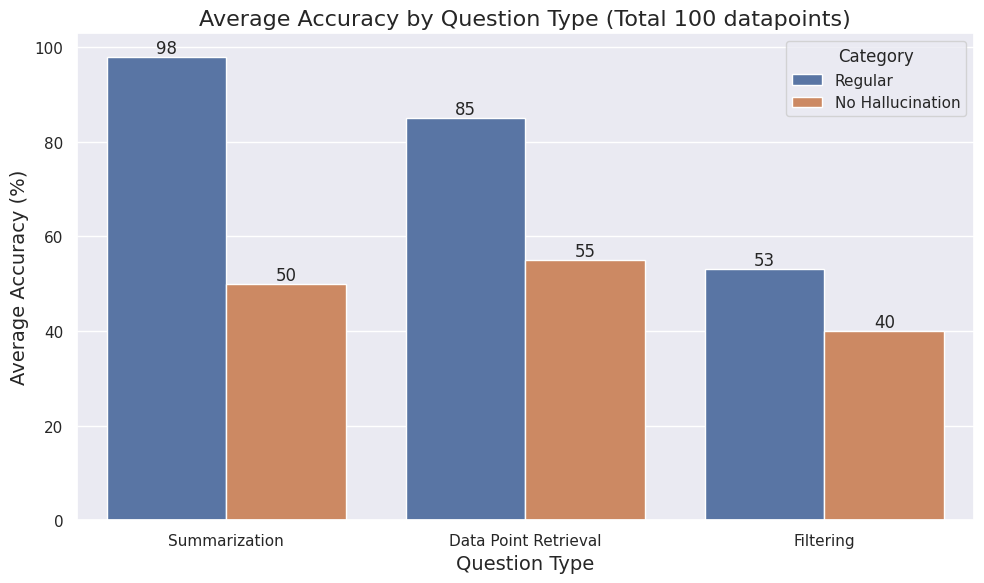

In [402]:
# Create the plot
plt.figure(
    figsize=(10, 6),
    tight_layout=True)

ax = plt.axes()
sns.barplot(data=df_combined, x='Type', y='Accuracy', hue='Category', palette='deep')
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12);

# Add title and labels
ax.set_title('Average Accuracy by Question Type (Total 100 datapoints)', fontsize=16)
ax.set_xlabel('Question Type', fontsize=14)
ax.set_ylabel('Average Accuracy (%)', fontsize=14)
# plt.xticks(rotation=45)

# Show plot with legend
ax.legend(title='Category')